In [38]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy.fft import fft,ifft

def dbscale(darray):
    if len(np.shape(darray))==3:
        img = 10*np.log10(abs(darray[:,:,0]+1j*darray[:,:,1])**2)
    else:
        img = 10*np.log10(abs(darray[:,:])**2)
    return img

def logScale(slices):
    
    logslices = np.copy(slices)
    nSlices = slices.shape[2]
    logslicesAmp = abs(logslices[:, :, :, 0] + 1j*logslices[:, :, :, 1])
    # and retrieve the phase
    logslicesPhase = np.angle(logslices[:, :, :, 0] + 1j*logslices[:, :, :, 1])
    # reescale amplitude
    logslicesAmp = np.log10(logslicesAmp)
    slicesMax = np.reshape(logslicesAmp.max(axis=(0, 1)), ( 1, 1,nSlices))
    slicesMin = np.reshape(logslicesAmp.min(axis=(0, 1)), ( 1, 1,nSlices))
    logslicesAmp = (logslicesAmp - slicesMin) / (slicesMax - slicesMin)
    # --- here, we could even normalize each slice to 0-1, keeping the original
    # --- limits to rescale after the network processes
    # and redefine the real and imaginary components with the new amplitude and
    # same phase
    logslices[:, :, :, 0] = (np.real(logslicesAmp * np.exp(1j*logslicesPhase)) + 1)/2
    logslices[:, :, :, 1] = (np.imag(logslicesAmp * np.exp(1j*logslicesPhase)) + 1)/2
    # print(np.max(logslicesPhase))
    # print(np.min(logslicesPhase))
    return logslices, slicesMax, slicesMin

def inverseLogScale(oldslices, slicesMax, slicesMin):
 
    slices = np.copy(oldslices)
    slices = (slices * 2) - 1
    slicesAmp = abs(slices[:, :, :, 0] + 1j*slices[:, :, :, 1])
    slicesPhase = np.angle(slices[:, :, :, 0] + 1j*slices[:, :, :, 1])
    slicesAmp = slicesAmp * (slicesMax - slicesMin) + slicesMin
    slicesAmp = 10**(slicesAmp)
    slices[:, :, :, 0] = np.real(slicesAmp * np.exp(1j*slicesPhase))
    slices[:, :, :, 1] = np.imag(slicesAmp * np.exp(1j*slicesPhase))
    return slices

def inverseLogScaleSummary(oldslices, slicesMax, slicesMin):
 
    slices = np.copy(oldslices)
    slices = (slices * 2) - 1
    slicesAmp = abs(slices[ :, :, 0] + 1j*slices[ :, :, 1])
    slicesPhase = np.angle(slices[ :, :, 0] + 1j*slices[ :, :, 1])
    slicesAmp = slicesAmp * (slicesMax - slicesMin) + slicesMin
    slicesAmp = 10**(slicesAmp)
    slices[:, :, 0] = np.real(slicesAmp * np.exp(1j*slicesPhase))
    slices[:, :, 1] = np.imag(slicesAmp * np.exp(1j*slicesPhase))
    return slices

def normalizePhase(tom):
    tomcx = tom[:,:,:,0]+1j*tom[:,:,:,1]
    amp = abs(tomcx)
    phase = np.angle(tomcx)
    min_fase = phase.min()
    max_fase = phase.max()
    a=-1*np.pi
    b=1*np.pi
    phase_normalized = (phase - min_fase) / (max_fase - min_fase) * (b - a) + a
    tomNormilized = amp*np.exp(1j*phase_normalized)
    return tomNormilized

In [45]:
dataPath = r'E:\DLOCT\Experimental_Data_complex'
# tom = np.load(os.path.join(dataPath,'validationOpticNerve.npy'))
# tomcc = np.load(os.path.join(dataPath,'validationOpticNervecc.npy'))
# tom = np.load(os.path.join(dataPath,'depthNail.npy'))
# tomcc = np.load(os.path.join(dataPath,'depthNailcc.npy'))
tom = np.load(os.path.join(dataPath,'depthFovea.npy'))
tomcc = np.load(os.path.join(dataPath,'depthFoveacc.npy'))
# tom = np.load(os.path.join(dataPath,'depthChicken.npy'))
# tomcc = np.load(os.path.join(dataPath,'depthChickencc.npy'))
size = 512
initz = 256
initx1 = 0
initx2 = 512
tomccNorm,imax,imin = logScale(tomcc)
tomHalfinitcc = tomccNorm[initz:initz+size,initx1:initx1+size,:,:]
tomHalfinit2cc = tomccNorm[initz:initz+size,initx2:,:,:]
tomccNorm = np.transpose(tomHalfinitcc, (2, 0, 1, 3))
tomccNorm2 = np.transpose(tomHalfinit2cc, (2, 0, 1, 3))

3.1415927
-3.1415915


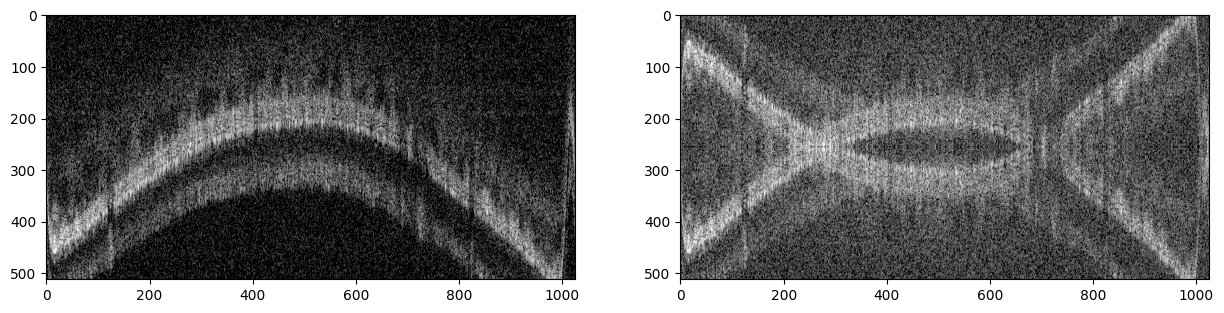

In [46]:
vmin = 60
vmax = 90
cmap='gray'
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(15,10))
axs[0].imshow(dbscale(tom[initz:initz+size,:,0,:]),cmap=cmap,vmin=vmin,vmax=vmax)
axs[0].axis=('off')
axs[1].imshow(dbscale(tomcc[initz:initz+size,:,0,:]),cmap=cmap,vmin=vmin,vmax=vmax)
axs[1].axis=('off')


In [12]:
path = r'E:\models\cxpix2pixcomplexdbscale\models'
modelName = 'model_131822.h5'
model = tf.keras.models.load_model(os.path.join(path,modelName), compile=False)

In [47]:
tomPredict = np.array(model.predict(tomccNorm, batch_size=1), dtype='float32')
tomPredictreordered = np.transpose(tomPredict, (1, 2, 0, 3))
tomPredictFullScale = inverseLogScale(tomPredictreordered,imax,imin)
tomPredict2 = np.array(model.predict(tomccNorm2, batch_size=1), dtype='float32')
tomPredictreordered2 = np.transpose(tomPredict2, (1, 2, 0, 3))
tomPredictFullScale2 = inverseLogScale(tomPredictreordered2,imax,imin)
tomPredictFullSize = np.concatenate((tomPredictFullScale,tomPredictFullScale2),axis=1)

10/10 [==============================] - 1s 135ms/step


Text(0.5, 1.0, 'Target')

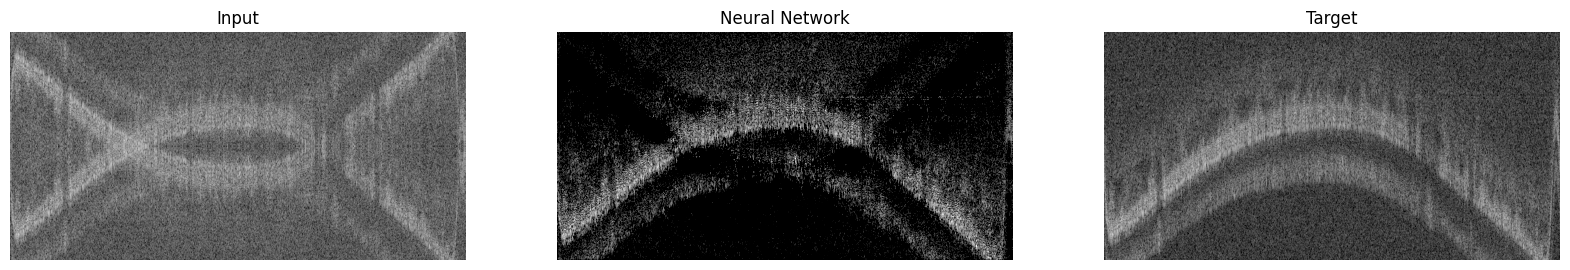

In [48]:
vmax = 100
vmin = 50
bscan = 2
fig,axs = plt.subplots(ncols=3,nrows=1,figsize=(20,15))
axs[0].imshow(dbscale(tomcc[initz:initz+size,:,bscan,:]),cmap='gray',vmax=vmax,vmin=vmin)
axs[0].axis('off')
axs[0].set_title('Input')
axs[1].imshow(dbscale(tomPredictFullSize[:,:,bscan,:]),cmap='gray',vmax=vmax,vmin=vmin)
axs[1].axis('off')
axs[1].set_title('Neural Network')
axs[2].imshow(dbscale(tom[initz:initz+size,:,bscan,:]),cmap='gray',vmax=vmax,vmin=vmin)
axs[2].axis('off')
axs[2].set_title('Target')